<a href="https://colab.research.google.com/github/Pablo-Lemos/orbits/blob/master/simple_orbits_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from scipy.ndimage import gaussian_filter
from scipy.ndimage import filters
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion


from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, Input
from keras.layers import concatenate, BatchNormalization
from keras.models import Model
from keras import optimizers

from io import BytesIO
from tensorflow.python.lib.io import file_io

from google.colab import auth
auth.authenticate_user()

from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print([x.name for x in local_device_protos if x.device_type == 'GPU'])

Using TensorFlow backend.


['/device:GPU:0']


In [0]:
class simple_leaky:
    """
    A simple MLP with LeakyReLU activation
    """
    
    def __init__(self, input_size, output_size, learning_rate=None):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.output_size = output_size
        
    def model(self):
        print(self.input_size)
        
        input_data = (Input(shape=(self.input_size,)))

        x1 = Dense(100, input_dim=self.input_size, kernel_initializer='normal')(input_data)
        x1 = LeakyReLU(alpha=0.1)(x1)
        x2 = Dense(100, kernel_initializer='normal')(x1)
        x2 = LeakyReLU(alpha=0.1)(x2)
        # x2 = Dropout(0.5)(x2)
        x3 = Dense(100, kernel_initializer='normal')(x2)
        x3 = LeakyReLU(alpha=0.1)(x3)
        # x3 = Dropout(0.5)(x3)
        x4 = Dense(self.output_size, kernel_initializer='normal')(x3)
        

        dense_model = Model(input_data, x4)
        dense_model.summary()

        if self.learning_rate is None:
            # dense_model.compile(optimizer='adam', loss='mse')
            dense_model.compile(optimizer='adam', loss='mean_absolute_error')
            # dense_model.compile(optimizer='adam', loss='mean_absolute_percentage_error')
        else:
            # dense_model.compile(optimizer=optimizers.Adam(lr=self.learning_rate), loss='mse')
            dense_model.compile(optimizer=optimizers.Adam(lr=self.learning_rate), loss='mean_absolute_error')

        return dense_model

# Make training data

In [0]:
n_body = 2
n_arrays = 50
n_training = 40
n_validation = n_arrays - n_training

assert n_validation > 0

In [0]:
def generate_target(orbit_array, shuffle=False, rescale = None):
    """
    Takes a single orbit and splits into input target points
    """

    input_array = orbit_array[:-1,:]
    target_array = orbit_array[1:,:]

    if shuffle:
      indices = np.arange(input_array.shape[0])
      np.random.shuffle(indices)
      input_array = input_array[indices]
      target_array = target_array[indices]

    if rescale is not None:
      rescale = np.outer(np.array(rescale), np.ones((input_array.shape[0],))).T
      input_array = rescale*input_array
      target_array = rescale*target_array

    return input_array, target_array

In [0]:
for i in np.arange(1,n_training):
  
  if i%10==0:
    print(i)

  

  orbit_temp = np.load(BytesIO(file_io.read_file_to_string('gs://orbits_ml/initial_data/planet_' + str(i) + '.npy',
                                                                 binary_mode=True)))
  
  
  orbit_temp  = np.vstack([orbit_temp[0,:,0],orbit_temp[0,:,1],
                           orbit_temp[0,:,3],orbit_temp[0,:,4],
                           orbit_temp[1,:,0],orbit_temp[1,:,1],
                           orbit_temp[1,:,3],orbit_temp[1,:,4]]).T

  # orbit_temp  = np.vstack([orbit_temp[1,:,0],orbit_temp[1,:,1],
  #                          orbit_temp[1,:,3],orbit_temp[1,:,4]]).T


  
  input_temp, target_temp = generate_target(orbit_temp, shuffle=True,
                                            rescale = [1.,1.,0.05,0.05, 
                                                       1.,1.,0.05,0.05])

  if i==1:
  # if i==0:
    input_training = np.copy(input_temp)
    target_training = np.copy(target_temp)
  else:
    input_training = np.vstack([input_training, input_temp])
    target_training = np.vstack([target_training, target_temp])


target_training = target_training[:,4:]


for i in np.arange(n_training,n_arrays):  

  if i%10==0:
    print(i)

  orbit_temp = np.load(BytesIO(file_io.read_file_to_string('gs://orbits_ml/initial_data/planet_' + str(i) + '.npy',
                                                                 binary_mode=True)))
  
  orbit_temp  = np.vstack([orbit_temp[0,:,0],orbit_temp[0,:,1],
                           orbit_temp[0,:,3],orbit_temp[0,:,4],
                           orbit_temp[1,:,0],orbit_temp[1,:,1],
                           orbit_temp[1,:,3],orbit_temp[1,:,4]]).T

  # orbit_temp  = np.vstack([orbit_temp[1,:,0],orbit_temp[1,:,1],
  #                          orbit_temp[1,:,3],orbit_temp[1,:,4]]).T
  
  input_temp, target_temp = generate_target(orbit_temp, shuffle=True,
                                            rescale = [1.,1.,0.05,0.05,
                                                       1.,1.,0.05,0.05])
  
  if i==n_training:
    input_validation = np.copy(input_temp)
    target_validation = np.copy(target_temp)
  else:
    input_validation = np.vstack([input_validation, input_temp])
    target_validation = np.vstack([target_validation, target_temp])

target_validation = target_validation[:,4:]
  

10
20
30
40


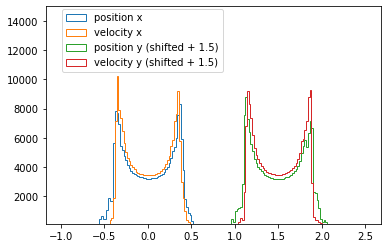

In [0]:

_ = plt.hist(target_training[:,0], bins = np.linspace(-1,1,101),
             label = 'position x', histtype='step')
_ = plt.hist(target_training[:,2], bins = np.linspace(-1,1,101),
             label = 'velocity x', histtype='step'), plt.legend()

_ = plt.hist(target_training[:,1] + 1.5, bins = np.linspace(0.5,2.5,101),
             label = 'position y (shifted + 1.5)', histtype='step')
_ = plt.hist(target_training[:,3]+ 1.5, bins = np.linspace(0.5,2.5,101),
             label = 'velocity y (shifted + 1.5)', histtype='step'), plt.legend(loc=(0.05,0.7))
_ = plt.ylim(100,15000)

# Traing network

In [0]:
model_instance = simple_leaky(input_training.shape[1], target_training.shape[1], learning_rate=1e-3)
predictor = model_instance.model()

8



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               900       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 100)              

In [0]:
history = predictor.fit(input_training[:], (target_training[:]-input_training[:,4:])*50.,
                         epochs =10,batch_size = 100, shuffle=True,
                         validation_data = (input_validation,
                                            50.*(target_validation-input_validation[:,4:])))




Train on 194961 samples, validate on 49990 samples
Epoch 1/10





194961/194961 [==============================] - 14s 74us/step - loss: 0.0048 - val_loss: 0.0041
Epoch 2/10
194961/194961 [==============================] - 7s 34us/step - loss: 0.0022 - val_loss: 0.0031
Epoch 3/10
194961/194961 [==============================] - 6s 33us/step - loss: 0.0017 - val_loss: 0.0026
Epoch 4/10
194961/194961 [==============================] - 6s 33us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 5/10
194961/194961 [==============================] - 6s 32us/step - loss: 0.0013 - val_loss: 0.0021
Epoch 6/10
194961/194961 [==============================] - 6s 32us/step - loss: 0.0012 - val_loss: 0.0017
Epoch 7/10
194961/194961 [==============================] - 6s 33us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 8/10
194961/194961 [==============================] - 6s 33us/step - loss: 0.0010 - val_loss: 0.0017
Epoch 9/10
194961/194961 [==============================] - 6s 33us/step - loss: 9.7

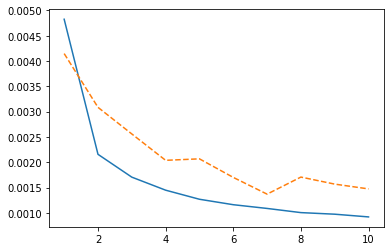

In [0]:
plt.plot(np.array(history.epoch)+1., history.history['loss'])
plt.plot(np.array(history.epoch)+1., history.history['val_loss'], '--')


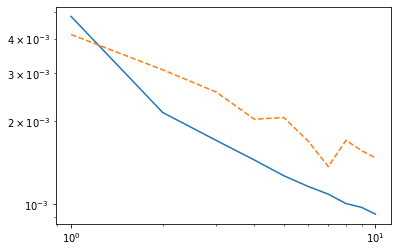

In [0]:
plt.loglog(np.array(history.epoch)+1., history.history['loss'])
plt.plot(np.array(history.epoch)+1., history.history['val_loss'], '--')


In [0]:
predictor.predict(np.atleast_2d(input_validation))[:,0]

array([ 0.10683762, -0.12382817,  0.10175738, ...,  0.10735846,
        0.02778544, -0.14313637], dtype=float32)

In [0]:
50.*(target_validation-input_validation[:,4:])[:,0]

array([ 0.10437465, -0.12348472,  0.09930284, ...,  0.10498132,
        0.02525553, -0.14344435])

0.0014029593387992478


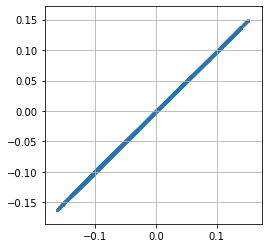

In [0]:
_ = plt.scatter(predictor.predict(np.atleast_2d(input_validation))[:,0],
                50.*(target_validation-input_validation[:,4:])[:,0],
                alpha = 3e-3, marker='.')
_ = plt.axis('equal')
_ = plt.axis('square'), plt.grid(True)

print(np.median(predictor.predict(np.atleast_2d(input_validation))[:,0]-
                50.*(target_validation-input_validation[:,4:])[:,0]))

-0.0007295847374970688


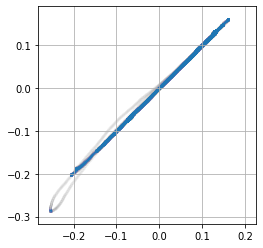

In [0]:
_ = plt.scatter(predictor.predict(np.atleast_2d(input_validation))[:,2],
                50.*(target_validation-input_validation[:,4:])[:,2],
                alpha = 3e-3, marker='.')
_ = plt.axis('equal')
_ = plt.axis('square'), plt.grid(True)

print(np.median(predictor.predict(np.atleast_2d(input_validation))[:,2]-
                50.*(target_validation-input_validation[:,4:])[:,2]))

In [0]:
print('Example derivative:')
print(predictor.predict(np.atleast_2d(input_validation[4700]))/50.)
print(target_validation[4700] -  input_validation[4700,4:])

Example derivative:
[[ 0.00232458  0.00140353  0.00093937 -0.00201035]]
[ 0.00231348  0.00141437  0.00091133 -0.00199361]


In [0]:
orbit_example = np.load(BytesIO(file_io.read_file_to_string('gs://orbits_ml/initial_data/planet_49.npy',
                                                                 binary_mode=True)))

orbit_example  = np.vstack([orbit_example[0,:,0]*1.,orbit_example[0,:,1]*1.,
                            orbit_example[0,:,3]*0.05,orbit_example[0,:,4]*0.05,
                           orbit_example[1,:,0]*1.,orbit_example[1,:,1]*1.,
                            orbit_example[1,:,3]*0.05,orbit_example[1,:,4]*0.05]).T


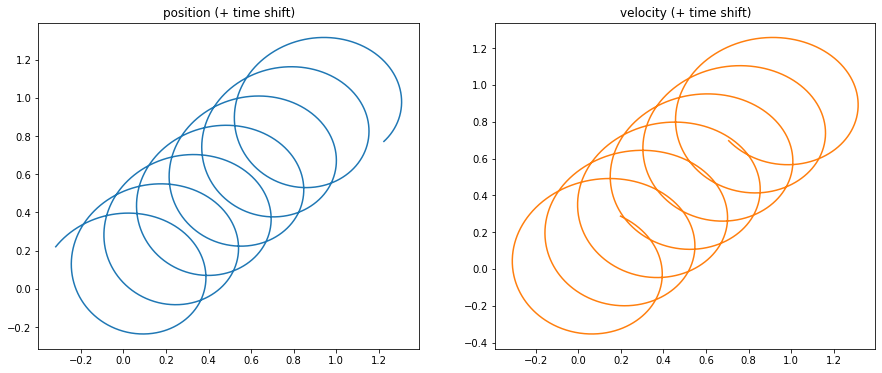

In [0]:
_ = plt.figure(figsize=(15,6)), plt.subplot(1,2,1), plt.title('position (+ time shift)')
_ = plt.plot(orbit_example[:,4] + np.arange(5000)*2e-4 ,
             orbit_example[:,5]+ np.arange(5000)*2e-4)
_ = plt.subplot(1,2,2), plt.title('velocity (+ time shift)')
_ = plt.plot(orbit_example[:,6]+ np.arange(5000)*2e-4,
             orbit_example[:,7]+ np.arange(5000)*2e-4, c='C1')

In [0]:
orbit_example_prediction = np.copy(orbit_example)
orbit_example_prediction = orbit_example_prediction[:,4:]
for i in range(orbit_example_prediction.shape[0]):
  if i%500==0:
    print(str(i) + '/' + str(orbit_example_prediction.shape[0]))
  if i > 0:
    delta = predictor.predict(np.atleast_2d(orbit_example[i-1,:]))/50. 
    orbit_example_prediction[i,:] = orbit_example_prediction[i-1] + delta

0/5000
500/5000
1000/5000
1500/5000
2000/5000
2500/5000
3000/5000
3500/5000
4000/5000
4500/5000


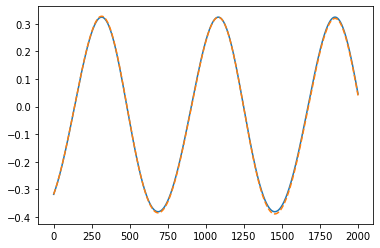

In [0]:
plt.plot(orbit_example[:2000,4])
plt.plot(orbit_example_prediction[:2000,0], '--')

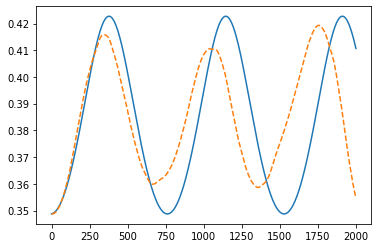

In [0]:
plt.plot(np.sqrt(orbit_example[:2000,6]**2. + orbit_example[:2000,7]**2.))
plt.plot(np.sqrt(orbit_example_prediction[:2000,2]**2. + orbit_example_prediction[:2000,3]**2.), '--')

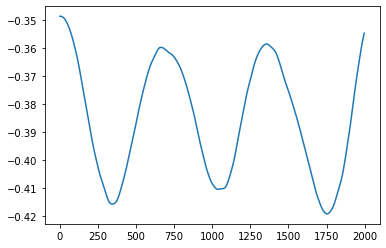

In [0]:
plt.plot(np.sqrt(orbit_example[1:2000,2]**2. + orbit_example[1:2000,3]**2.)-
         np.sqrt(orbit_example_prediction[1:2000,2]**2. + orbit_example_prediction[1:2000,3]**2.))

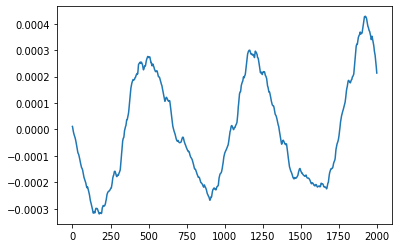

In [0]:
plt.plot((np.sqrt(orbit_example[1:2000,2]**2. + orbit_example[1:2000,3]**2.)-
         np.sqrt(orbit_example_prediction[1:2000,2]**2. + orbit_example_prediction[1:2000,3]**2.))-
         (np.sqrt(orbit_example[:1999,2]**2. + orbit_example[:1999,3]**2.)-
         np.sqrt(orbit_example_prediction[:1999,2]**2. + orbit_example_prediction[:1999,3]**2.)))

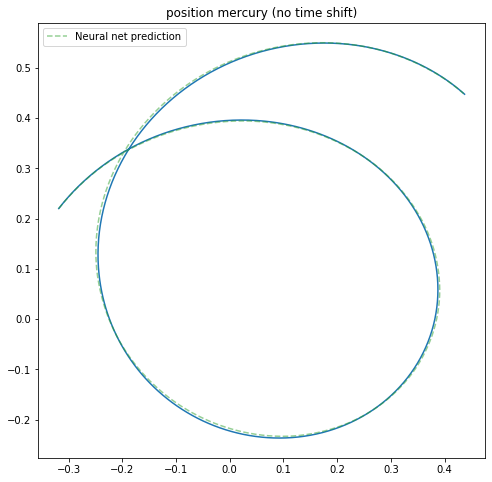

In [0]:
_ = plt.figure(figsize=(8,8)), plt.title('position mercury (no time shift)')
_ = plt.plot(orbit_example[:1000,4] + np.arange(1000)*2e-4,
             orbit_example[:1000,5]+ np.arange(1000)*2e-4)
_ = plt.plot(orbit_example_prediction[:1000,0]+ np.arange(1000)*2e-4 ,
             orbit_example_prediction[:1000,1]+ np.arange(1000)*2e-4, '--', c='C2', alpha=0.5, label='Neural net prediction')
_ = plt.legend()

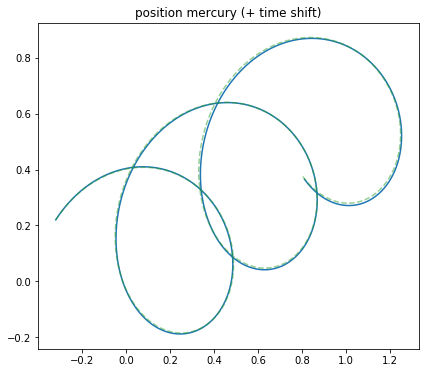

In [0]:
_ = plt.figure(figsize=(15,6)), plt.subplot(1,2,1), plt.title('position mercury (+ time shift)')
_ = plt.plot(orbit_example[:2100,4] + np.arange(2100)*5e-4,
             orbit_example[:2100,5]+ np.arange(2100)*3e-4)
_ = plt.plot(orbit_example_prediction[:2100,0]+ np.arange(2100)*5e-4 ,
             orbit_example_prediction[:2100,1]+ np.arange(2100)*3e-4, '--', c='C2', alpha=0.5)

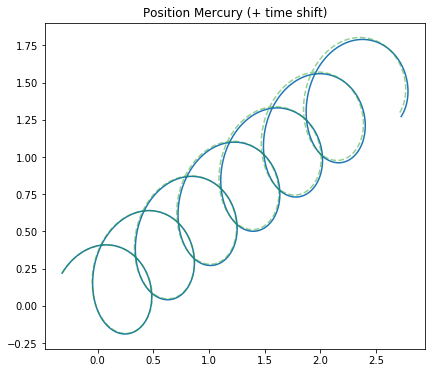

In [0]:
_ = plt.figure(figsize=(15,6)), plt.subplot(1,2,1)
_ = plt.title('Position Mercury (+ time shift)')
_ = plt.plot(orbit_example[:,4] + np.arange(5000)*5e-4,
             orbit_example[:,5]+ np.arange(5000)*3e-4,
             label = 'Simulated', )
_ = plt.plot(orbit_example_prediction[:,0]+ np.arange(5000)*5e-4 ,
             orbit_example_prediction[:,1]+ np.arange(5000)*3e-4, '--', c='C2',
             label = 'MLP prediction', alpha=0.5)